# Preparing Bell state using VQE

__By performing bell basis measurement one can discriminate between two bell states. In general it's not possible to discriminate all the 4 bell states using LOCC__

In [3]:
#Import libraries
import numpy as np
from scipy.optimize import minimize
from pyquil import Program, get_qc
import pyquil.api as api
from pyquil.gates import *
qvm = api.QVMConnection()
from grove.pyvqe.vqe import VQE
from math import pi
import warnings
warnings.filterwarnings('ignore')

__Define the Hamiltonian__

In [4]:
# Define the matrix
from pyquil.paulis import PauliSum, PauliTerm
Ham = PauliSum([PauliTerm.from_list([("Z", 1), ("Z", 0)], coefficient=-1)])

__Choose ansatz__

In [161]:
num_qubit=2 
depth=1

# ansatz
def ansatz(theta):
    p = Program()
    p+=H(0)
    p+=H(0)
    k=0
    for i in range(depth):
           p+=CNOT(0,1)
           p+=RY(-pi/2, 1)
           p+=RX(theta[k], 1)
           p+=RY(pi/2, 1)
           p+=CNOT(0,1)
           p+=RX(1-theta[k], 0)
           p+=RX(1-theta[k], 1)
    k=k+1
    return p

__Optimization with VQE__

In [162]:
# Minimize and get approximate of the lowest eigenvalue
from grove.pyvqe.vqe import VQE
#qc = get_qc('2q-qvm')
vqe = VQE(minimizer=minimize, minimizer_kwargs={'method': 'nelder-mead','options': {'xatol': 1.0e-2}})

__Running the program without sample size__

In [165]:
np.random.seed()
initial_params = np.random.uniform(0.0, 2*np.pi, size=2*depth)
result = vqe.vqe_run(ansatz, Ham, initial_params)
print(result)

                     models will be ineffective
{'x': array([1.        , 1.57452825]), 'fun': -0.9999999999999998}


__Running the program with sample size=1000__

In [168]:
result = vqe.vqe_run(ansatz, Ham, initial_params, samples=1000)
print(result)

{'x': array([0.99978425, 1.79091577]), 'fun': -1.0}


__sample size=100__

In [166]:
result = vqe.vqe_run(ansatz, Ham, initial_params, samples=100)
print(result)

{'x': array([1.52724855, 1.42625731]), 'fun': -0.94}


__sample size=10__

In [174]:
result = vqe.vqe_run(ansatz, Ham, initial_params, samples=10)
print(result)

{'x': array([1.67963754, 1.38428272]), 'fun': -1.0}


__sample size=1__

In [183]:
result = vqe.vqe_run(ansatz, Ham, initial_params, samples=1)
print(result)

{'x': array([1.5996548 , 1.38428272]), 'fun': -1.0}


__Variational Circuit__

In [184]:
print(ansatz(result.x))

H 0
H 0
CNOT 0 1
RY(-pi/2) 1
RX(1.599654799644064) 1
RY(pi/2) 1
CNOT 0 1
RX(-0.599654799644064) 0
RX(-0.599654799644064) 1



__Here Hadamard gate is used, which can be constructed using Rx and Ry gates with constant parameters__

__For depth=1 we can loop over a range of these angles and plot the expectation value__

In [185]:
num_qubit=2 
depth=1

# ansatz
def ansatz(theta):
    p = Program()
    p+=H(0)
    p+=H(0)
    k=0
    for i in range(depth):
           p+=CNOT(0,1)
           p+=RY(-pi/2, 1)
           p+=RX(theta[k], 1)
           p+=RY(pi/2, 1)
           p+=CNOT(0,1)
           p+=RX(1-theta[k], 0)
           p+=RX(1-theta[k], 1)
    k=k+1
    return p

In [186]:
vqe_inst = VQE(minimizer=minimize, minimizer_kwargs={'method': 'nelder-mead'})

In [187]:
angle_range = np.linspace(0.0, 2 * np.pi, 50)
data = [vqe_inst.expectation(ansatz([angle]), Ham, None, qvm) for angle in angle_range]

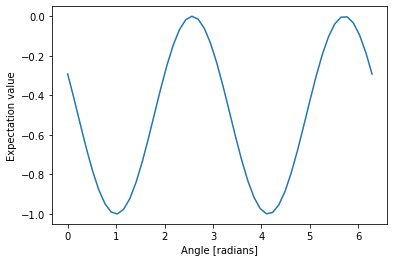

In [188]:
import matplotlib.pyplot as plt 
plt.xlabel('Angle [radians]') 
plt.ylabel('Expectation value') 
plt.plot(angle_range, data) 
plt.show()

__<font size="4">The expectation value $\approx -1$ (depth=1, sample=None)</font>__

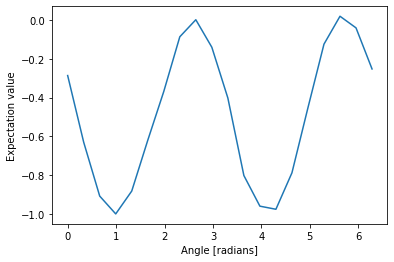

In [189]:
import warnings
warnings.filterwarnings('ignore')
angle_range = np.linspace(0.0, 2 * np.pi, 20)
data = [vqe_inst.expectation(ansatz([angle]), Ham, 1000, qvm) for angle in angle_range]
import matplotlib.pyplot as plt 
plt.xlabel('Angle [radians]') 
plt.ylabel('Expectation value') 
plt.plot(angle_range, data) 
plt.show()

__<font size="4">The expectation value $\approx -1$ (depth=1, sample=1000)</font>__

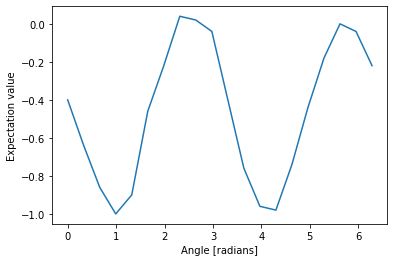

In [191]:
angle_range = np.linspace(0.0, 2 * np.pi, 20)
data = [vqe_inst.expectation(ansatz([angle]), Ham, 100, qvm) for angle in angle_range]
import matplotlib.pyplot as plt 
plt.xlabel('Angle [radians]') 
plt.ylabel('Expectation value') 
plt.plot(angle_range, data) 
plt.show()

__<font size="4">The expectation value $\approx -1$ (depth=1, sample=100)</font>__ 

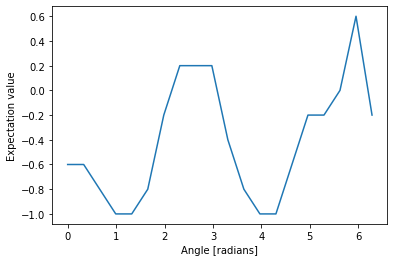

In [197]:
angle_range = np.linspace(0.0, 2 * np.pi, 20)
data = [vqe_inst.expectation(ansatz([angle]), Ham, 10, qvm) for angle in angle_range]
import matplotlib.pyplot as plt 
plt.xlabel('Angle [radians]') 
plt.ylabel('Expectation value') 
plt.plot(angle_range, data) 
plt.show()

__<font size="4">The expectation value $\approx -1$ (depth=1, sample=10)</font>__ 

## Running VQE under noise

In [198]:
pauli_channel = [0.01, 0.01, 0.01]
noisy_qvm = api.QVMConnection(gate_noise=pauli_channel)

In [199]:
initial_angle = [0.5]
vqe_inst.minimizer_kwargs = {'method': 'Nelder-mead', 'options': {'initial_simplex': np.array([[0.0], [0.05]]), 'xatol': 1.0e-2}}
result = vqe_inst.vqe_run(ansatz, Ham, initial_angle, samples=1000, qvm=noisy_qvm)

In [200]:
print(result)

{'x': array([0.91875]), 'fun': -0.742}


In [229]:
data = []
noises = np.linspace(0.0, 0.01, 4)
for noise in noises:
    pauli_channel = [noise] * 3
    noisy_qvm = api.QVMConnection(gate_noise=pauli_channel)
    result = vqe_inst.vqe_run(ansatz, Ham, initial_angle, samples=1000, qvm=noisy_qvm, gate_noise=pauli_channel)
    #vqe_inst.vqe_run(ansatz, Ham, initial_angle,gate_noise=pauli_channel)
    data.append(result['fun'])

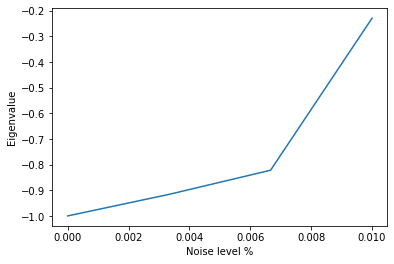

In [230]:
plt.xlabel('Noise level %') 
plt.ylabel('Eigenvalue') 
plt.plot(noises, data) 
plt.show()